In [22]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import scDML
from scDML import scDMLModel
from scDML.utils import print_dataset_information

In [23]:
panc_8 = ad.read_h5ad('/goofys/users/Aleksandra_S/benchmarking_datasets/human_pancreas_norm_complexBatch.h5ad')
dataset="bct"
panc_8.obs['BATCH'] = panc_8.obs.tech
print_dataset_information(panc_8,batch_key="BATCH",celltype_key="celltype")

===========print brief infomation of dataset ===============
===========there are 9 batchs in this dataset==============
===========there are 14 celltypes with this dataset=========


celltype,acinar,activated_stellate,alpha,beta,delta,ductal,endothelial,epsilon,gamma,macrophage,mast,quiescent_stellate,schwann,t_cell,Total
BATCH,,,,,,,,,,,,,,,
celseq,228,19,191,161,50,327,5,1,18,1,1,1,1,0,1004
celseq2,274,90,843,445,203,258,21,4,110,15,6,12,4,0,2285
fluidigmc1,21,16,239,258,25,36,14,1,18,1,3,1,5,0,638
inDrop1,110,51,236,872,214,120,130,13,70,14,8,92,5,2,1937
inDrop2,3,81,676,371,125,301,23,2,86,17,9,22,6,2,1724
inDrop3,843,100,1130,787,161,376,92,2,36,14,7,54,1,2,3605
inDrop4,2,52,284,495,101,280,7,1,63,10,1,5,1,1,1303
smarter,0,0,886,472,49,0,0,0,85,0,0,0,0,0,1492
smartseq2,188,55,1008,308,127,444,21,8,213,7,7,6,2,0,2394


In [5]:
adata_copy=panc_8.copy()
# sc.pp.normalize_total(adata_copy,target_sum=1e4)
# sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=1000,subset=True)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
sc.pp.neighbors(adata_copy)

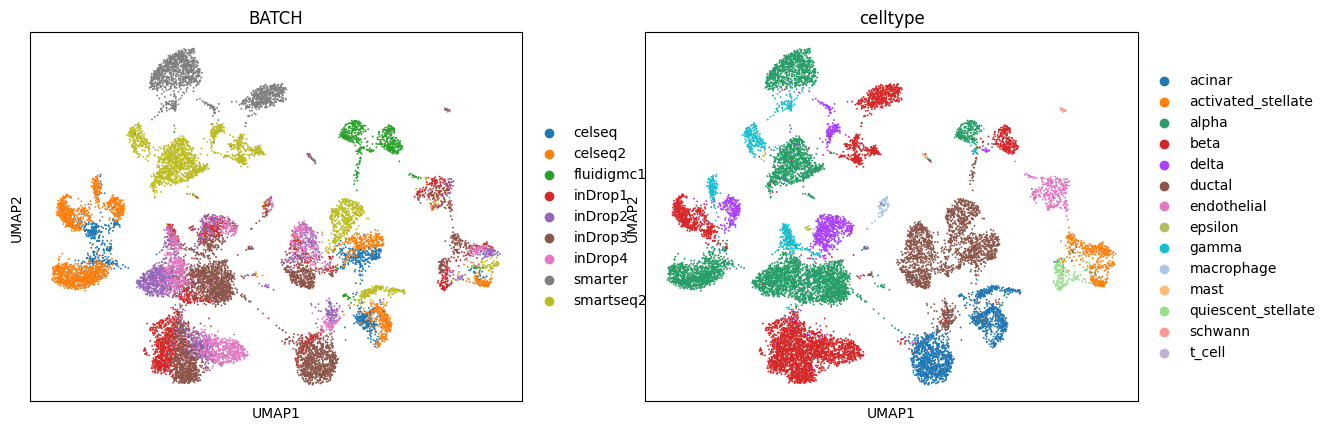

In [6]:

sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy,color=["BATCH","celltype"])

In [7]:
scdml = scDMLModel(save_dir="./result/"+dataset+"/",verbose=False) 

In [9]:
adata=scdml.preprocess(panc_8, cluster_method="louvain", resolution=3.0, n_high_var=2000, normalize_samples=False, log_normalize=False)
print(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.
AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', 'BATCH', 'batch', 'init_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'mean-5', 'std-5', 'mean-6', 'std-6', 'mean-7', 'std-7', 'mean-8', 'std-8'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'


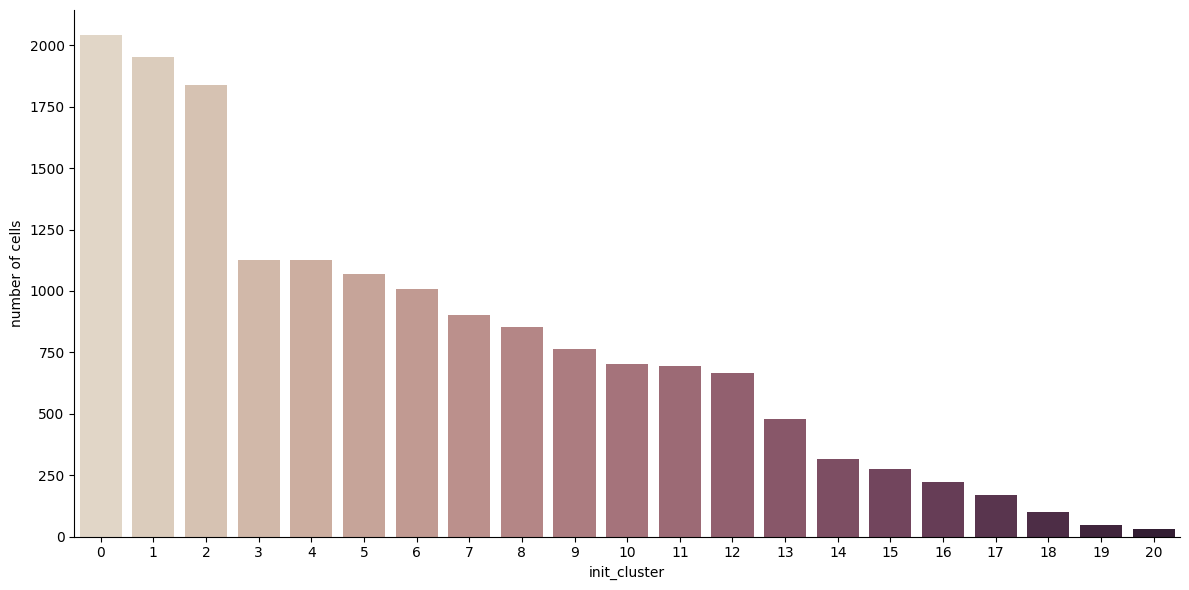

In [10]:
# overview the distribution of cluster after init clustering
ax=sns.catplot(x="init_cluster", kind="count", palette="ch:.25",data=adata.obs,height=6,aspect=2)
ax.set(ylabel='number of cells')
plt.show()

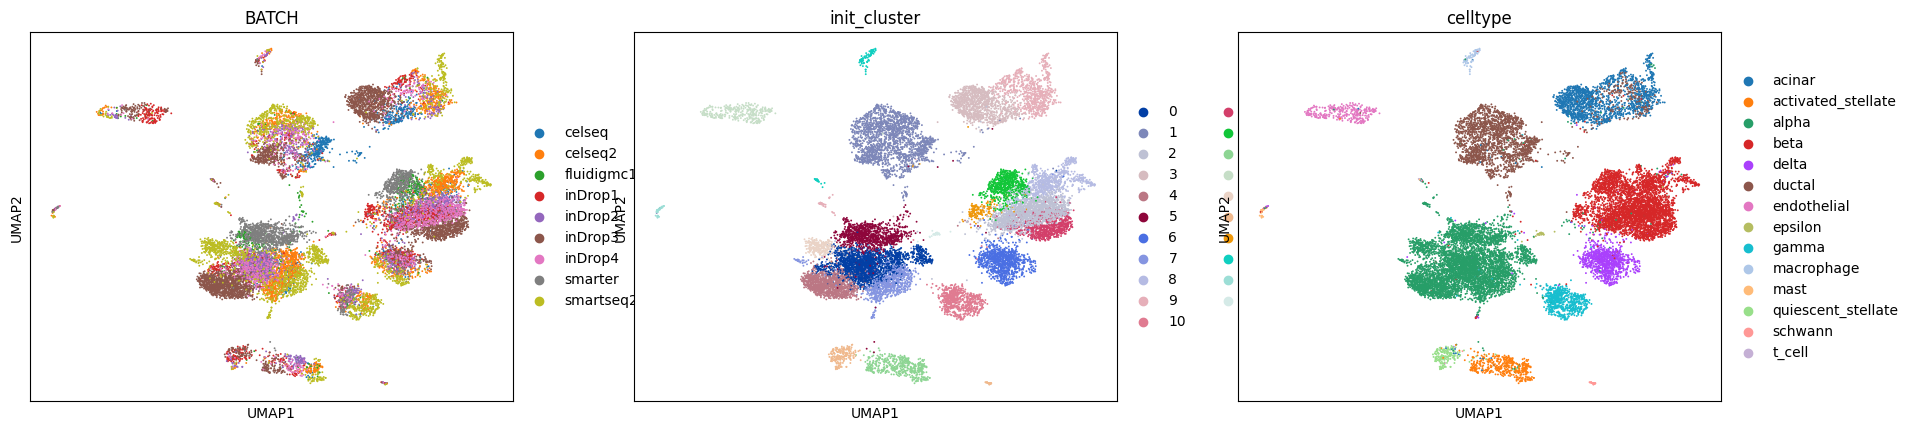

In [12]:
# visluzation of preprocessed adata
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["BATCH","init_cluster", "celltype"])

<Figure size 1500x1000 with 0 Axes>

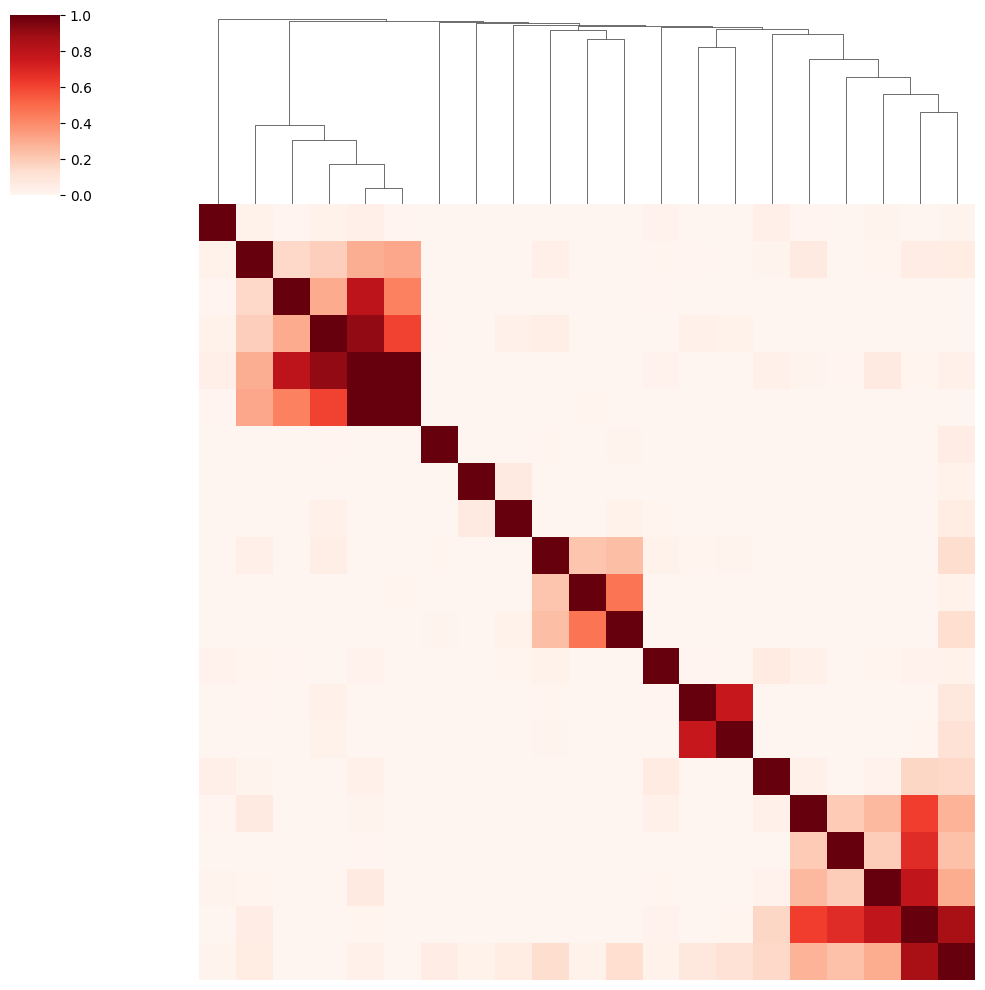

In [13]:
from scDML.utils import plotDendrogram,plotHeatMap
# convert adata to training data for neural network
scdml.convertInput(adata,batch_key="BATCH")
_,_,cor,_ = scdml.calculate_similarity()

fig = plt.figure(figsize=(15,10))
Z=plotDendrogram(scdml.cor_matrix.copy(),scdml.nn_matrix.copy(),
                           scdml.merge_df["init_cluster"].value_counts().values.copy())
hf=plotHeatMap(scdml.cor_matrix.copy(),Z)
plt.show()

In [21]:
from scDML.utils import plotSankey
import plotly.graph_objs as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

ncluster_list=[10,8,6,4,3]# for example
merge_df=scdml.merge_cluster(ncluster_list=ncluster_list,merge_rule="rule2")
merge_df["celltype"]=adata.obs["celltype"].values

cols=["init_cluster"]+[str(i) for i in ncluster_list]+["celltype"]
fig=plotSankey(merge_df,cat_cols=cols,value_cols='value',title="Sanky plot")

plotly.offline.iplot(fig)

In [14]:
scdml.build_net()

In [15]:
scdml.merge_cluster(ncluster_list=[14])

2023-08-02 08:09:59,751 - root - INFO - scDML merge cluster with rule2....
2023-08-02 08:09:59,754 - root - INFO - merge_rule2....
2023-08-02 08:10:00,148 - root - INFO - merging cluster set:[{3}, {5}, {8}, {14}, {20}, {24}, {25}, {30}, {34}, {1, 19, 28, 17}, {26, 10, 23, 31}, {16, 29}, {0, 33, 2, 4, 12, 15, 18, 21, 22, 27}, {32, 6, 7, 9, 11, 13}]


,init_cluster,value,14
D101_5-0,8,1.0,14(2)
D101_43-0,8,1.0,14(2)
D101_93-0,8,1.0,14(2)
D102_4-0,8,1.0,14(2)
D172444_23-0,8,1.0,14(2)
...,...,...,...
HP1504901_A22-8,25,1.0,14(6)
HP1504901_M11-8,25,1.0,14(6)
HP1504901_N21-8,25,1.0,14(6)
HP1507101_P15-8,25,1.0,14(6)


In [16]:
# delete trained model to retrain the model
if os.path.isfile(os.path.join(scdml.save_dir,"scDML_model.pkl")):
    os.remove(os.path.join(scdml.save_dir,"scDML_model.pkl"))
    
features=scdml.train(expect_num_cluster=14)
# adata.obsm["X_emb"]=features
# adata.obs["reassign_cluster"]=scdml.train_label.astype(int).astype(str)
# adata.obs["reassign_cluster"]=adata.obs["reassign_cluster"].astype("category")

2023-08-02 08:10:07,324 - root - INFO - train scDML(expect_num_cluster=14) with Embedding Net
2023-08-02 08:10:07,325 - root - INFO - expect_num_cluster=14
2023-08-02 08:10:07,330 - root - INFO - using CPU to train model
2023-08-02 08:10:07,345 - root - INFO - use euclidean distance and hard triplet to train model
2023-08-02 08:10:07,347 - root - INFO - not use earlystopping!!!!
2023-08-02 08:10:09,305 - root - INFO - epoch=1,number_hard_triplet=205434
2023-08-02 08:10:11,250 - root - INFO - epoch=2,number_hard_triplet=90864
2023-08-02 08:10:12,842 - root - INFO - epoch=3,number_hard_triplet=53670
2023-08-02 08:10:15,069 - root - INFO - epoch=4,number_hard_triplet=34291
2023-08-02 08:10:17,164 - root - INFO - epoch=5,number_hard_triplet=24992
2023-08-02 08:10:19,087 - root - INFO - epoch=6,number_hard_triplet=19164
2023-08-02 08:10:21,443 - root - INFO - epoch=7,number_hard_triplet=15584
2023-08-02 08:10:23,391 - root - INFO - epoch=8,number_hard_triplet=10555
2023-08-02 08:10:25,059 -

In [17]:
adata.obsm["X_emb"]=features
adata.obs["reassign_cluster"]=scdml.train_label.astype(int).astype(str)
adata.obs["reassign_cluster"]=adata.obs["reassign_cluster"].astype("category")

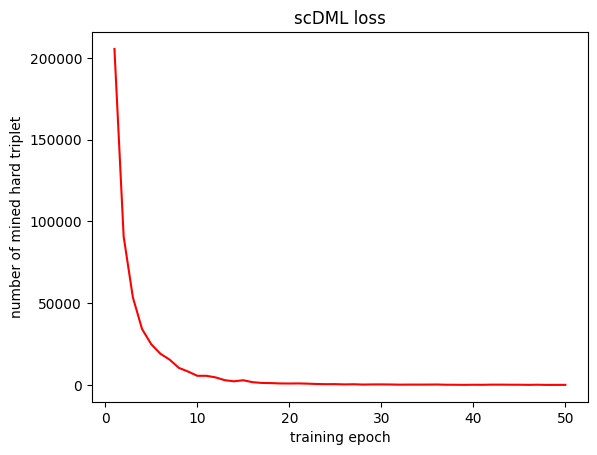

In [18]:
# plot loss
fig=plt.figure()
plt.title("scDML loss")
plt.plot(range(1,len(scdml.loss)+1),scdml.loss,c="r")
plt.xlabel("training epoch")
plt.ylabel("number of mined hard triplet")
plt.show()

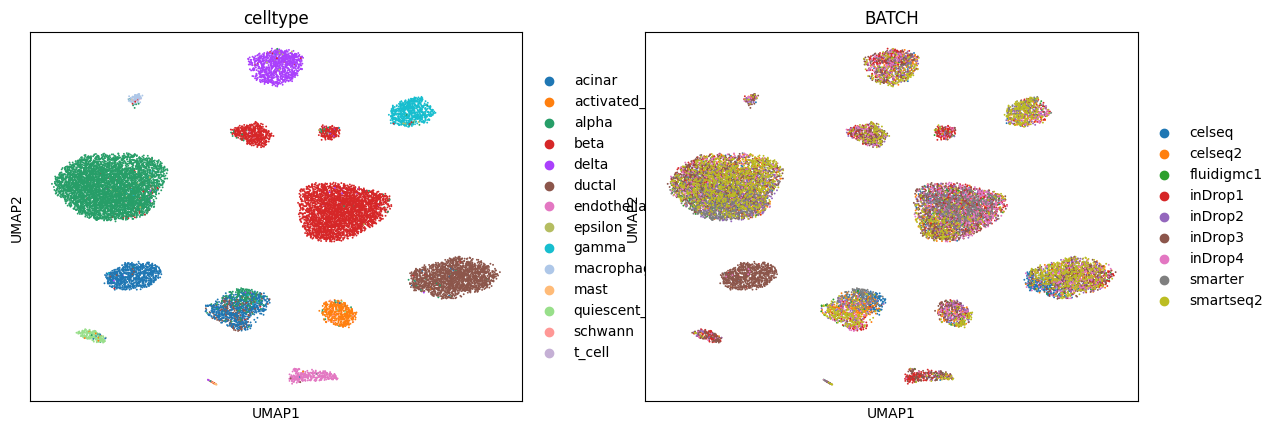

In [19]:
sc.pp.neighbors(adata,use_rep="X_emb",random_state=0)
sc.tl.umap(adata)

sc.pl.umap(adata,color=["celltype","BATCH"])
#sc.pl.umap(adata,color=["celltype","reassign_cluster"],legend_loc="on data",legend_fontsize="xx-large")

In [20]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
ari=adjusted_rand_score(adata.obs["reassign_cluster"],adata.obs["celltype"])
nmi=normalized_mutual_info_score(adata.obs["reassign_cluster"],adata.obs["celltype"])
print(f"ARI={ari}")
print(f"NMI={nmi}")

ARI=0.849888179269779
NMI=0.8448321443477695
